In [1]:
import torch
import torchvision
from torch.nn.functional import interpolate
import numpy as np
import math

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

In [2]:
from improved_diffusion import dist_util, logger
from improved_diffusion.image_datasets import load_data
from improved_diffusion.resample import create_named_schedule_sampler
from improved_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
    add_dict_to_argparser,
)
from improved_diffusion.train_util import TrainLoop

from tqdm.notebook import tqdm, trange

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)


# # Display functions
# We will work with PyTorch images with color values in $[-1,1]$ and the usual additional batch dimension.
# Images will have size 1x3x1024x1024 in PyTorch.

Device: cuda:0


# Model

In [46]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t, labels):
    """
    Display a tensor as an image using Matplotlib with labels.

    Parameters:
    t (torch.Tensor): The input tensor containing the images.
    labels (list of str): The labels for each image.
    
    Returns:
    None
    """
    t = 0.5 + 0.5 * t.to('cpu')
    t = t.squeeze()
    t = t.clamp(0., 1.).detach()

    # Number of images
    num_images = t.shape[2] // t.shape[1]

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
    
    if num_images>1:
      for i, ax in enumerate(axes):
          img = t[:, :, i * t.shape[1]:(i + 1) * t.shape[1]]
          ax.imshow(img.permute(1, 2, 0))
          ax.set_title(labels[i], fontsize=16)
          ax.axis('off')
    else:
      img = t
      axes.imshow(img.permute(1, 2, 0))
      axes.set_title(labels[0], fontsize=16)
      axes.axis('off')

    plt.show()


# # Load DDPM Unet

In [4]:
config = {
    'image_size': 256,
    'num_channels': 192,
    'num_res_blocks': 3,
    'diffusion_steps': 1000,
    'noise_schedule': 'cosine',
    'num_heads': 4,
    'num_heads_upsample': -1,
    'attention_resolutions': "16,8",
    'dropout': 0.0,
    'learn_sigma': False,
    'sigma_small': False,
    'class_cond': False,
    'timestep_respacing': "",
    'use_kl': False,
    'predict_xstart': False,
    'rescale_timesteps': True,
    'rescale_learned_sigmas': True,
    'use_checkpoint': False,
    'use_scale_shift_norm': True,
}

In [6]:
model, diffusion = create_model_and_diffusion(
    **config
)
import os
model.load_state_dict(torch.load(os.path.join(os.environ["WORK"],"DDPMv2/improved-diffusion/models/openai-2024-08-27-04-32-47-086669/ema_0.9999_078000.pt"), map_location='cpu'))
model = model.to(device)
# use in eval mode:
model.eval();

In [7]:
# Print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in the model: {count_parameters(model)}")

Number of parameters in the model: 369547779


In [8]:
# Function to define the beta scheduling

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                    produces the cumulative product of (1-beta) up to that
                    part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                    prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [22]:
class DDPM:
  def __init__(self, model=model, DDIM=False):
    self.num_diffusion_timesteps = 1000
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    #self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps, dtype=np.float64)   # linear scheduling
    self.betas = betas_for_alpha_bar(
            self.num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )   # cosine scheduling
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,3,256,256)
    self.DDIM = DDIM

  def get_eps_from_model(self, x, t):
    # the model outputs:
    # - an estimation of the noise eps (channels 0 to 2)
    # - learnt variances for the posterior  (channels 3 to 5)
    # (see Improved Denoising Diffusion Probabilistic Models
    # by Alex Nichol, Prafulla Dhariwal
    # for the parameterization)
    # We discard the second part of the output for this practice session.
    model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
    model_output = model_output[:,:3,:,:]
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sample(self, show_steps=True):
    with torch.no_grad():  # avoid backprop wrt model parameters
        xt = torch.randn(self.imgshape, device=device)  # initialize x_t for t=T
        for i, t in enumerate(self.reversed_time_steps):
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alphas_cumprod[t]
            alpha_bar_prev_t = self.alphas_cumprod_prev[t]

            eps = self.get_eps_from_model(xt, t)
            xhat = self.predict_xstart_from_eps(xt, eps, t)

            if self.DDIM:
                # Using the deterministic path for DDIM
                x0_pred = self.predict_xstart_from_eps(xt, eps, t)
                # Update xt using the deterministic DDIM update
                if t > 0:
                    xt = np.sqrt(alpha_bar_prev_t) * x0_pred + np.sqrt(1 - alpha_bar_prev_t) * eps
            else:
                # Standard DDPM update with noise
                #z = torch.randn(self.imgshape, device=device) if t > 1 else torch.zeros(self.imgshape, device=device)
                #sigma_t = np.sqrt(self.betas[t])
                #xt = 1 / np.sqrt(alpha_t) * (xt - (1 - alpha_t) / np.sqrt(1 - alpha_bar_t) * eps) + sigma_t * z

                beta_t = self.betas[t]
                sigma_t = np.sqrt(beta_t)

                z = torch.randn(self.imgshape, device=device) if t > 1 else torch.zeros(self.imgshape, device=device)

                xt = np.sqrt(alpha_t) * (1-alpha_bar_prev_t) / (1-alpha_bar_t) * xt
                xt += np.sqrt(alpha_bar_prev_t)*beta_t / (1-alpha_bar_t)*xhat
                xt += sigma_t*z


            if show_steps and t % 200 == 0:
                print('Iteration:', t)
                labels = [r"Diffusion step x_t", r"Prediction $x_{hat}$"]
                pilimg = display_as_pilimg(torch.cat((xt, self.predict_xstart_from_eps(xt, eps, t)), dim=3)[:,:3], labels)

    return xt

  
  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):
      if vis_y is None:
          vis_y = y

      # Initialize xt for t=T
      x = torch.randn(self.imgshape, device=device)
      x.requires_grad = True

      for t in tqdm(self.reversed_time_steps[1:]):  # Start from the last timestep

          alpha_t = self.alphas[t]
          alpha_bar_t = self.alphas_cumprod[t]
          alpha_bar_tm1 = self.alphas_cumprod_prev[t]

          eps = self.get_eps_from_model(x, t)
          xhat = self.predict_xstart_from_eps(x, eps, t)

          if self.DDIM:
            # Using DDIM, update x deterministically
            if t > 0:
                x_prime = np.sqrt(alpha_bar_tm1) * xhat + np.sqrt(1 - alpha_bar_tm1) * eps
            else:
                x_prime = xhat  # At the last step, we converge to the deterministic prediction

          else:
            if t > 0:
              beta_t = self.betas[t]
              sigma_t = np.sqrt(beta_t)

              z = torch.randn(self.imgshape, device=device)

              x_prime = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x
              x_prime += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat
              x_prime += sigma_t*z

              df_term = torch.sum((y-linear_operator(xhat))**2)
              grad = torch.autograd.grad(df_term, x)[0]
              zeta = 1 / torch.sqrt(df_term)

              x = x_prime - zeta * grad
            else:
              x = xhat
            
          
          # MODIFY THE DISPLAY PROCEDURE ADDING LABELS


          if show_steps and ((t)%200==0):
            print('Iteration :', t)
            if t==0:
              labels = [r"Observation $y$", r"HST", r"Diffusion step $x_0$"]
              pilimg = display_as_pilimg(torch.cat((interpolate(y, size=(256, 256), mode='bilinear', align_corners=False), interpolate(x_true, size=(256, 256), mode='bilinear', align_corners=False), x), dim=3), labels)
            else:
              labels = [r"Diffusion step $x_t$", r"Prediction $x_{hat}$", r"Processed $x_{hat}$", r"Observation $y$", r"HST"]
              pilimg = display_as_pilimg(torch.cat((x, xhat, interpolate(linear_operator(xhat), size=(256, 256), mode='bilinear', align_corners=False), interpolate(y, size=(256, 256), mode='bilinear', align_corners=False), interpolate(x_true, size=(256, 256), mode='bilinear', align_corners=False)), dim=3), labels)
          else:
            if t==0:
              labels = [r"Diffusion step $x_0$", r"Observation $y$", r"HST"]
              pilimg = display_as_pilimg(torch.cat((x, interpolate(y, size=(256, 256), mode='bilinear', align_corners=False), interpolate(x_true, size=(256, 256), mode='bilinear', align_corners=False)), dim=3), labels)

      return x



ddpm = DDPM(DDIM=False)

# Sampling

In [10]:
# 
# Let us recall that the DDPM transition probability is given by
# $$ p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_{t}) = \mathcal{N}(\mu_\theta(\mathbf{x}_{t}, t), \beta_t I_d) $$
# where
# $$
# \mu_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\mathbf{\varepsilon}_\theta(\mathbf{x}_t,t) \right).
# $$
# 

#sample = ddpm.sample(show_steps=False)

#display_as_pilimg(sample, ["Sample"])

# Conditional sampling for imaging inverse problems

## Pixels scaling and Redshift

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import astropy.units
from astropy.cosmology import Planck15
from scipy.ndimage import zoom
from astropy.nddata import block_reduce

# Pixel conversion factors
pixel_conversion = {
    'HSC': 0.17 * astropy.units.arcsec,  # arcsec / pixel
    'JWST': 0.03 * astropy.units.arcsec  # arcsec / pixel
}

# Create an instance of the Planck 2015 cosmology
cosmo = Planck15

def summarize_cosmology():
    # Access various cosmological parameters
    H0 = cosmo.H0  # Hubble constant in km/s/Mpc
    Omega_m = cosmo.Om0  # Matter density parameter
    Omega_lambda = cosmo.Ode0  # Dark energy density parameter

    print("Hubble constant (H0):", H0)
    print("Matter density parameter (Omega_m):", Omega_m)
    print("Dark energy density parameter (Omega_lambda):", Omega_lambda)

def histogram(data, **hist_kwargs):
    data_hist = data.flatten()
    plt.hist(data_hist.numpy(), **hist_kwargs)

def plot_image(image_data, vmin=None, vmax=None, title=''):
    if vmin is None: vmin = torch.min(image_data)
    if vmax is None: vmax = torch.max(image_data)
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    plt.imshow(image_data.permute(1, 2, 0).cpu().numpy(), vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.show()

def arcsec_to_radian(x):
    return np.pi / 648000 * x

def radian_to_arcsec(x):
    return x / (np.pi / 648000)

def get_down_scale_factor(z=0.1, unit_pixel_in_kpc=0.4, experiment='HSC'):
    """
    Returns the scale factor at which the image has to be decreased for a given redshift.
    If the scale factor is >1, we decrease the image size.
    """
    arcsec_per_kpc_at_z = Planck15.arcsec_per_kpc_proper(z)
    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc
    down_scale_factor = 1 / unit_pixel * pixel_conversion[experiment] / arcsec_per_kpc_at_z

    if down_scale_factor.unit == '':
        return down_scale_factor.value
    else:
        raise ValueError("Error, factor carries a unit.")

def get_image_in_janski(image_data, z):
    unit_pixel_in_kpc = 0.4
    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc
    pixel_width_in_arcsec = Planck15.arcsec_per_kpc_proper(z) * unit_pixel
    image_in_janskis = pixel_width_in_arcsec.value ** 2 * image_data
    return image_in_janskis

def get_downscaled_image_at_z_in_janski(image_data, z, experiment='HSC', use_zoom_func=False):
    image_data_in_janski = get_image_in_janski(image_data, z=z)
    reduce_factor = get_down_scale_factor(z, experiment=experiment)

    if use_zoom_func:
        scale_factor = 1 / reduce_factor
        new_size = (int(image_data_in_janski.shape[-2] * scale_factor), int(image_data_in_janski.shape[-1] * scale_factor))
        image_smaller = F.interpolate(image_data_in_janski, size=new_size, mode='bilinear', align_corners=False)
    else:
        # Not yet implemented in pytorch version
        image_smaller = block_reduce(image_data_in_janski, (1, 1, reduce_factor, reduce_factor))

    return image_smaller

def normalize_min_max_func(x):
    """
    Normalize each channel of the tensor to the range [0, 1].
    
    Parameters:
    x (torch.Tensor): The input tensor.
    
    Returns:
    torch.Tensor: The normalized tensor.
    """
    min_val = x.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    max_val = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    return (x - min_val) / (max_val - min_val + 1e-18)

def _ScaleImage(img, z=0.1, experiment='HSC', new_size=256, normalize_min_max=True):
    """
    A function that converts the image as a tensor to the desired format.
    """
    rescaled_image = get_downscaled_image_at_z_in_janski(
        image_data=img,
        z=z,
        experiment=experiment,
        use_zoom_func=True
    )

    if not isinstance(rescaled_image, torch.Tensor):
        rescaled_image = torch.from_numpy(rescaled_image) if isinstance(rescaled_image, np.ndarray) else torch.tensor(rescaled_image)

    # Resize and crop or pad the image to the new size
    #rescaled_image = rescaled_image.unsqueeze(0).unsqueeze(0) if rescaled_image.dim() == 2 else rescaled_image.unsqueeze(0)
    #rescaled_image = F.interpolate(rescaled_image, size=(new_size, new_size), mode='bilinear', align_corners=False)

    if normalize_min_max:
        return normalize_min_max_func(rescaled_image)
    else:
        return rescaled_image

## Tests

In [12]:
def crop_center(img, cropx, cropy, offsetx=0, offsety=0):
    """
    Crop the center of an image with an optional offset.

    Parameters:
    img (numpy.ndarray or torch.Tensor): The input image.
    cropx (int): The width of the cropped image.
    cropy (int): The height of the cropped image.
    offsetx (int, optional): The horizontal offset for the center. Default is 0.
    offsety (int, optional): The vertical offset for the center. Default is 0.

    Returns:
    numpy.ndarray or torch.Tensor: The cropped image.
    """
    y, x = img.shape[-2:]  # Handle both 2D and 3D images
    centerx = x // 2 + offsetx
    centery = y // 2 + offsety
    startx = max(centerx - cropx // 2, 0)
    starty = max(centery - cropy // 2, 0)
    endx = min(centerx + cropx // 2, x)
    endy = min(centery + cropy // 2, y)
    return img[..., starty:endy, startx:endx]

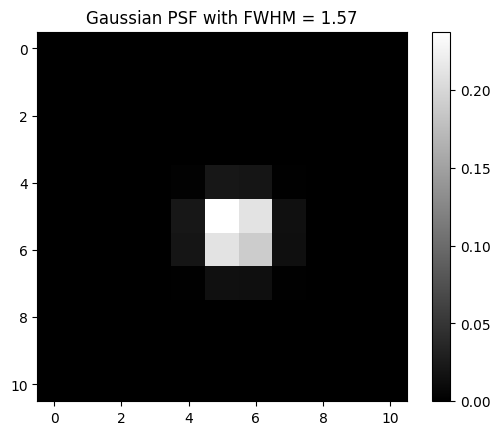

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def create_gaussian_psf(psf_fwhm, size=11):
    """
    Create a Gaussian PSF given the FWHM.

    Parameters:
    psf_fwhm (float): Full Width at Half Maximum of the PSF.
    size (int): Size of the output PSF array. Default is 51x51.

    Returns:
    numpy.ndarray: 2D array representing the Gaussian PSF.
    """
    # Convert FWHM to standard deviation
    sigma = psf_fwhm / (2 * np.sqrt(2 * np.log(2)))

    # Create a grid of (x, y) coordinates
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)

    # Calculate the Gaussian PSF
    psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    psf /= psf.sum()  # Normalize the PSF

    return psf

psf_fwhm = 1.64  # Example FWHM value
PSF_g = create_gaussian_psf(psf_fwhm)

psf_fwhm = 1.54  # Example FWHM value
PSF_r = create_gaussian_psf(psf_fwhm)

psf_fwhm = 1.57  # Example FWHM value
PSF_i = create_gaussian_psf(psf_fwhm)

psf_kernel = torch.from_numpy(np.dstack((PSF_g, PSF_r, PSF_i)).transpose((2,0,1))).float()

# Plot the PSF
plt.imshow(PSF_g, cmap='gray')
plt.colorbar()
plt.title(f'Gaussian PSF with FWHM = {psf_fwhm}')
plt.show()


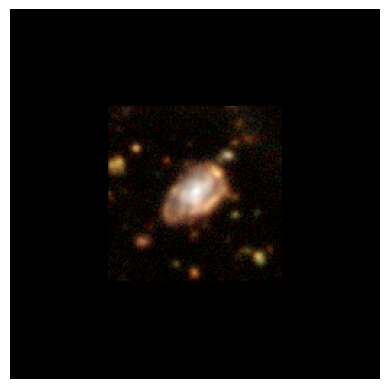

In [56]:
from astropy.io import fits

r = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/HSC PDR3/example14/cutout-HSC-G-9813-pdr3_dud_rev-5.fits')
g = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/HSC PDR3/example14/cutout-HSC-R-9813-pdr3_dud_rev-5.fits')
b = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/HSC PDR3/example14/cutout-HSC-I-9813-pdr3_dud_rev-5.fits')


from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, SinhStretch, LogStretch, LinearStretch, AsinhStretch)

r = r[1].data
g = g[1].data
b = b[1].data

# Change from AB Mag to flux

r = 10 ** ((22.5 - 2.5*np.log10(np.maximum(1e-11,r)) - 8.9) / (-2.5))
g = 10 ** ((22.5 - 2.5*np.log10(np.maximum(1e-11,g)) - 8.9) / (-2.5))
b = 10 ** ((22.5 - 2.5*np.log10(np.maximum(1e-11,b)) - 8.9) / (-2.5))

PSF_g = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/HSC PDR3/example14/psf-calexp-pdr3_dud_rev-HSC-G-9813-5.fits')
PSF_r = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/HSC PDR3/example14/psf-calexp-pdr3_dud_rev-HSC-R-9813-5.fits')
PSF_i = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/HSC PDR3/example14/psf-calexp-pdr3_dud_rev-HSC-I-9813-5.fits')

x_smallest = min(PSF_g[0].data.shape[0], PSF_r[0].data.shape[0], PSF_i[0].data.shape[0])
y_smallest = min(PSF_g[0].data.shape[1], PSF_r[0].data.shape[1], PSF_i[0].data.shape[1])

PSF_g = crop_center(PSF_g[0].data, y_smallest, x_smallest)
PSF_r = crop_center(PSF_r[0].data, y_smallest, x_smallest)
PSF_i = crop_center(PSF_i[0].data, y_smallest, x_smallest)


psf_kernel = torch.from_numpy(np.dstack((PSF_g, PSF_r, PSF_i)).transpose((2,0,1))).float()

interval = MinMaxInterval()
transform = AsinhStretch(a=0.1) + interval

max_r, max_g, max_b = 3.3911525e-05, 8.840797e-05, 0.00013950268
min_r, min_g, min_b = -2.0621407e-07, -2.3600744e-07, -3.6527842e-07

crop = torchvision.transforms.CenterCrop(256)

r = transform(crop(torch.tensor(r)).numpy())
g = transform(crop(torch.tensor(g)).numpy())
b = transform(crop(torch.tensor(b)).numpy())

rgb_image = np.dstack((r, g, b))

x_true = pilimg_to_tensor(np.dstack((r, g, b)))
# Stack arrays into a 3D array for RGB image
#rgb_image = np.dstack((r, g, b))

#rgb_image = Image.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/cat (1).png').convert('RGB')
#x_true = pilimg_to_tensor(rgb_image)

# Plot the RGB image WITHOUT CHANGE OF SCALE
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

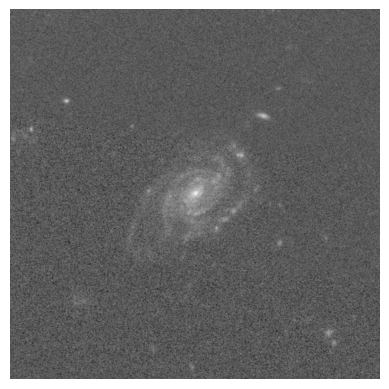

In [67]:
HST_i = fits.open('/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/HSC PDR3/example14/HST-channel-I-5.fits')

interval = MinMaxInterval()
transform = AsinhStretch(a=0.1) + interval

HST_i = HST_i[0].data
HST_i = np.array([HST_i,HST_i,HST_i])

HST_i = np.transpose(transform(HST_i), (1, 2, 0))  # Transpose
#HST_i = np.rot90(HST_i, 1)  # Rotate 90 degrees

HST = pilimg_to_tensor(HST_i.copy())

plt.imshow(HST_i, cmap='gray')
plt.axis('off')
plt.show()

In [58]:
z = 0.8463

def pre_process(img, z=z, experiment='HSC', new_size=256, normalize_min_max=True):
    return _ScaleImage((img+1)/2, experiment=experiment, new_size=new_size, z=z, normalize_min_max=normalize_min_max)*2 - 1

def pre_process2(img, z=z, experiment='HSC', new_size=256, normalize_min_max=False):
    return _ScaleImage(img, experiment=experiment, new_size=new_size, z=z, normalize_min_max=normalize_min_max)

In [64]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import numpy as np


def apply_psf_kernel(x, psf_kernel=psf_kernel):
    """
    Applies the provided PSF kernel to each channel of a tensor x.
    
    Parameters:
    - x (torch.Tensor): The input tensor of shape [N, C, H, W].
    - psf_kernel (torch.Tensor): The PSF kernel of shape [C, kernel_size, kernel_size].
    
    Returns:
    - torch.Tensor: The tensor after applying the PSF kernel.
    """

    device = x.device  # Get the device from the input tensor
    channels = x.size(1)  # Assuming x has shape [N, C, H, W]
    original_size = x.shape[2:]
    
    # Ensure the PSF kernel has the shape [C, 1, kernel_size, kernel_size]
    if psf_kernel.dim() == 3:
        psf_kernel = psf_kernel.unsqueeze(1).to(device)
    
    # Apply convolution using the multi-channel PSF kernel
    kernel_size = psf_kernel.size(2)  # Assuming square kernels
    padding = kernel_size // 2
    x_psf = F.conv2d(x, psf_kernel, padding=padding, groups=channels)
    x_psf = TF.center_crop(x_psf, original_size)
    
    return x_psf.float()

In [60]:
def normalize_min_max_func2(x):
    """
    Normalize each channel of the tensor to the range [0, 1].
    
    Parameters:
    x (torch.Tensor): The input tensor.
    
    Returns:
    torch.Tensor: The normalized tensor.
    """
    min_val = x.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    max_val = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    return (x - min_val) / (max_val - min_val + 1e-18)

def inverse_normalize_min_max_func2(x, min_r=min_r, min_g=min_g, min_b=min_b, max_r=max_r, max_g=max_g, max_b=max_b):
    """
    Reverse the normalization applied by normalize_min_max_func2.
    
    Parameters:
    x (torch.Tensor): The input tensor to be denormalized.
    min_r, min_g, min_b (float): Minimum values for the red, green, and blue channels respectively.
    max_r, max_g, max_b (float): Maximum values for the red, green, and blue channels respectively.
    
    Returns:
    torch.Tensor: The denormalized tensor.
    """
    # Create tensors for min and max values for each channel
    min_vals = torch.tensor([min_r, min_g, min_b], device=x.device).view(-1, 1, 1)
    max_vals = torch.tensor([max_r, max_g, max_b], device=x.device).view(-1, 1, 1)
    
    # Reverse the normalization
    return (x * (max_vals - min_vals) + min_vals).float()

cuda:0
noisy measurement


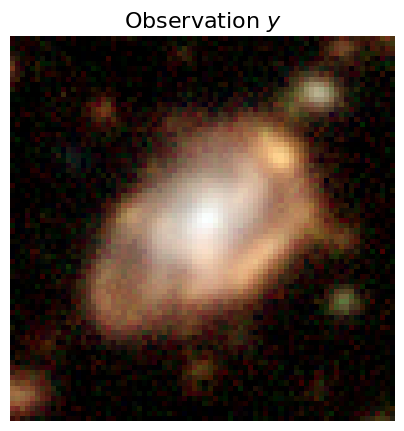

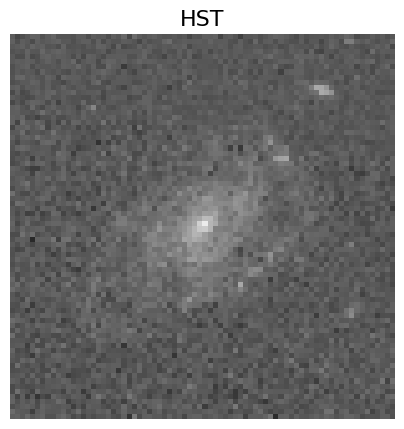

In [68]:
x_noisy = pilimg_to_tensor(rgb_image)
new_shapes = [i // 2 for i in list(x_noisy.shape[2:4])]
HST = TF.center_crop(interpolate(HST, size=new_shapes, mode='bilinear', align_corners=False), pre_process(x_true).shape[2:])

x_noisy = TF.center_crop(x_noisy, pre_process(x_true).shape[2:])
print(x_noisy.device)

sigma_noise = 2*0/255

y = 2*normalize_min_max_func2(x_noisy.clone()) - 1  + sigma_noise * torch.randn_like(x_noisy)
print("noisy measurement")
display_as_pilimg(y, labels=[r"Observation $y$"]);
display_as_pilimg(HST, labels=[r"HST"]);

In [69]:
def asinh_stretch(tensor, a):
    """
    Apply the asinh stretch to the input tensor.
    
    Parameters:
    tensor (torch.Tensor): The input tensor to be stretched.
    a (float): The stretch parameter.
    
    Returns:
    torch.Tensor: The asinh stretched tensor.
    """
    return torch.asinh(tensor / a) / torch.asinh(torch.tensor(1.0 / a))

def inverse_asinh_stretch(tensor, a):
    """
    Apply the inverse of the asinh stretch to the input tensor.
    
    Parameters:
    tensor (torch.Tensor): The input tensor to be inversely stretched.
    a (float): The stretch parameter.
    
    Returns:
    torch.Tensor: The inverse asinh stretched tensor.
    """
    return a * torch.sinh(tensor * torch.asinh(torch.tensor(1.0 / a)))

def composition2(x, func1 = pre_process2, func2 = apply_psf_kernel, a1 = 0.01, a2 = 0.1):
    return normalize_min_max_func2(asinh_stretch(func2(func1(inverse_asinh_stretch(inverse_normalize_min_max_func2((x+1)/2), a1))), a2))*2 - 1

def composition(x, func1 = pre_process, func2 = apply_psf_kernel):
    return func2(func1(x))

  0%|          | 0/999 [00:00<?, ?it/s]

Iteration : 800


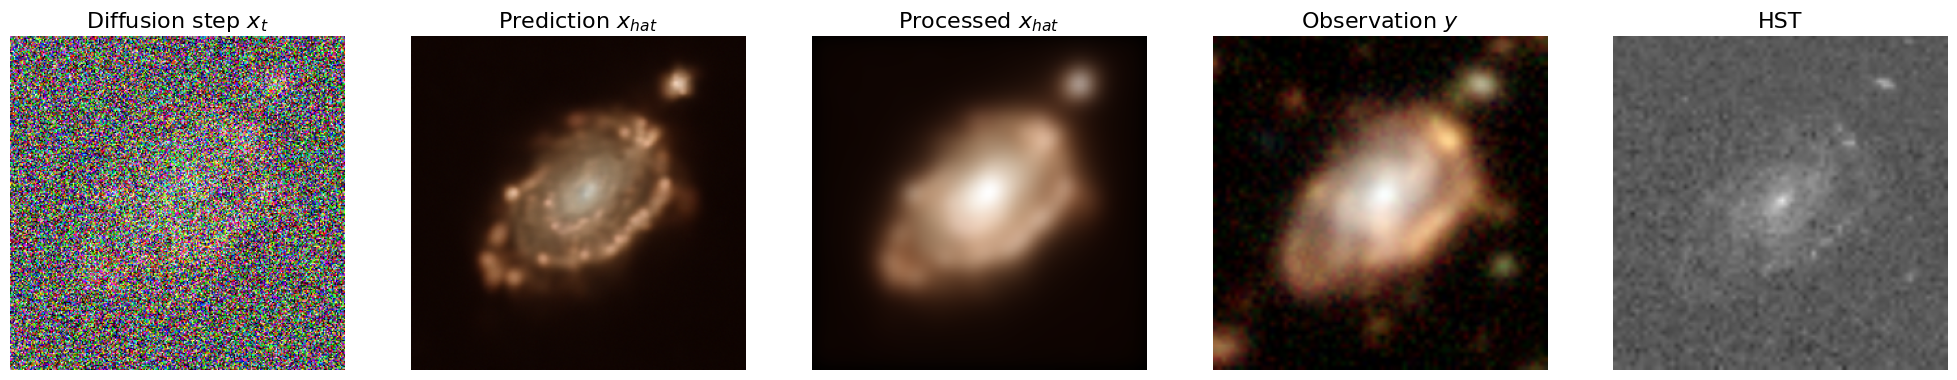

Iteration : 600


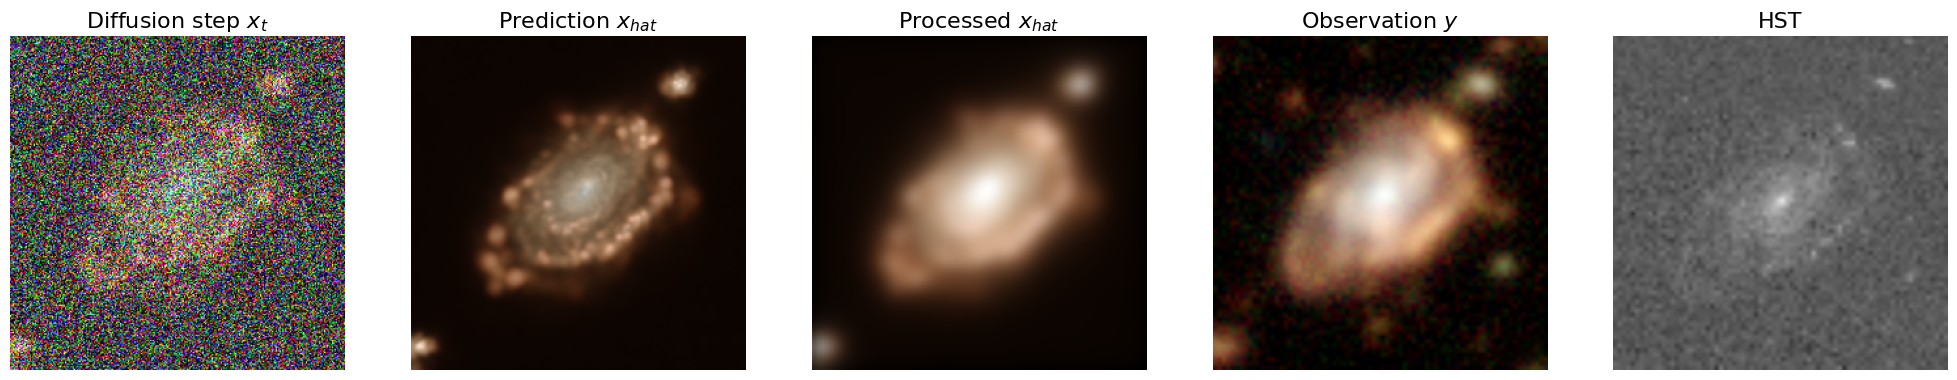

Iteration : 400


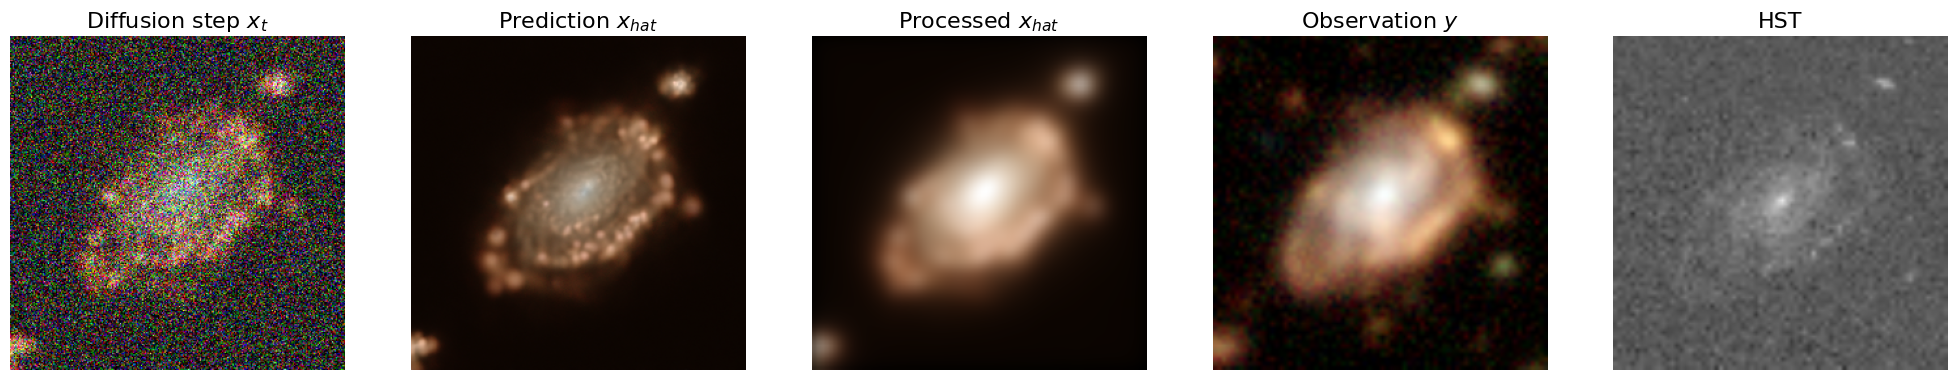

Iteration : 200


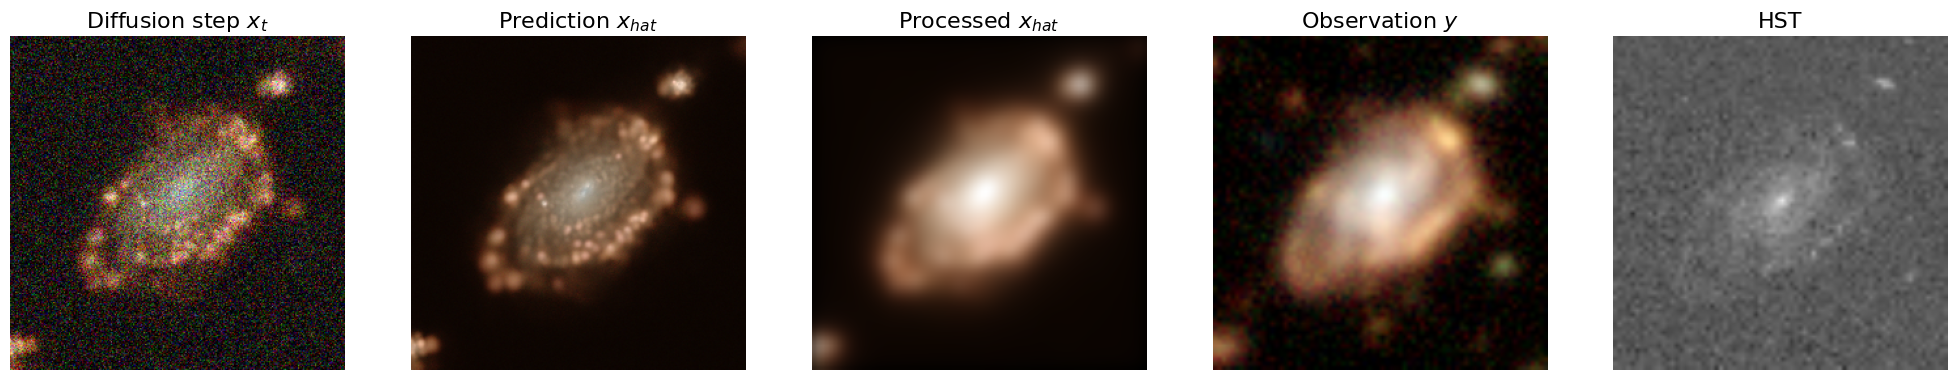

Iteration : 0


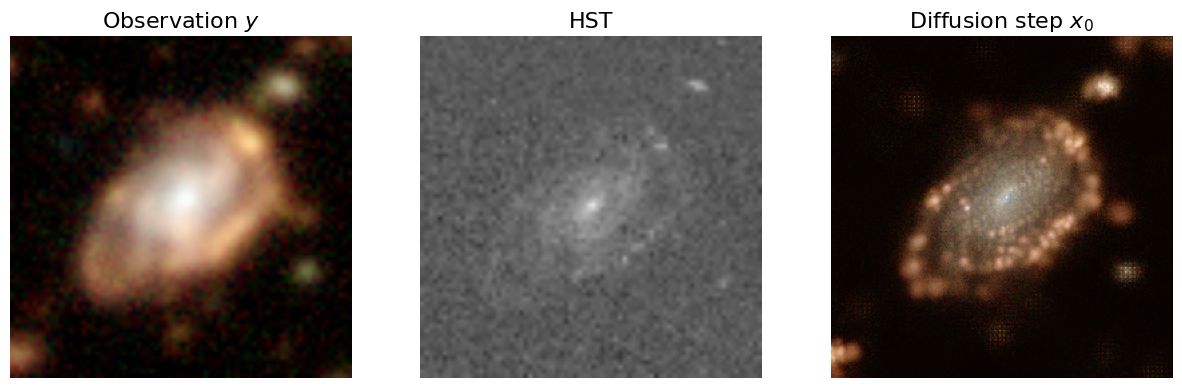

In [71]:
restored_image = ddpm.posterior_sampling(composition2, y, x_true=HST, show_steps=True)

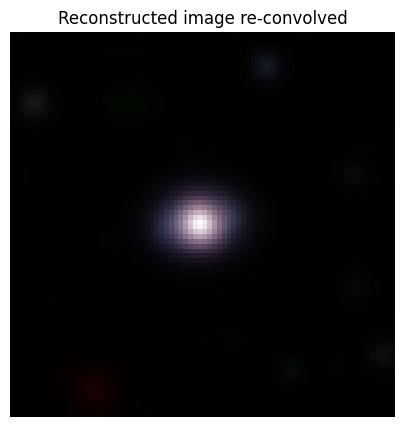

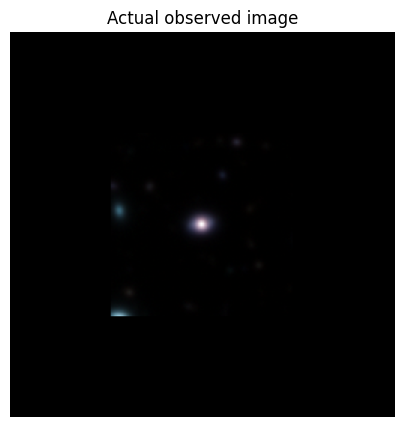

In [ ]:
display_as_pilimg(composition2(restored_image), labels=["Reconstructed image re-convolved"]);
display_as_pilimg(pilimg_to_tensor(rgb_image), labels=["Actual observed image"]);

In [ ]:
from psftools.utils import image as metrics

The pyoperator library is not installed. Cannot use the pcg_solver_single method.


In [ ]:
print("First moments")
print("Idealized: ", metrics.first_moments(HST.squeeze(0)[0].detach().cpu().numpy()))
print("Restored: ", metrics.first_moments(restored_image.squeeze(0)[2].detach().cpu().numpy()))
print("Observed: ", metrics.first_moments(y.squeeze(0)[2].detach().cpu().numpy()))
print("Restored Reconvolved: ", metrics.first_moments(composition2(restored_image).squeeze(0)[2].detach().cpu().numpy()))

First moments
Idealized:  (39.4698136821355, 39.527046315811944)
Restored:  (127.52364074414302, 127.5689547356884)
Observed:  (39.51791232413409, 39.5653893003872)
Restored Reconvolved:  (39.51700788998038, 39.5746740474011)


In [ ]:
print("Second moments")
print("Idealized: ", metrics.second_moments(HST.squeeze(0)[0].detach().cpu().numpy()))
print("Restored: ", metrics.second_moments(restored_image.squeeze(0)[2].detach().cpu().numpy()))
print("Observed: ", metrics.second_moments(y.squeeze(0)[2].detach().cpu().numpy()))
print("Restored Reconvolved: ", metrics.second_moments(composition2(restored_image).squeeze(0)[2].detach().cpu().numpy()))

Second moments
Idealized:  (538.9641982210168, 538.8700877130154, -0.19308026841911513)
Restored:  (5535.692899941515, 5536.271911084507, -4.3446080591528835)
Observed:  (551.8084390283985, 552.1225456072534, -1.0708803013624353)
Restored Reconvolved:  (550.4199029458028, 549.8771701956501, -1.0292115453334973)


In [ ]:
print("Ellipticity")
print("Idealized: ", metrics.get_ellipticity(HST.squeeze(0)[0].detach().cpu().numpy(), sigma=0.75, pixscl=0.4))
print("Restored: ", metrics.get_ellipticity(restored_image.squeeze(0)[2].detach().cpu().numpy(), sigma=0.75, pixscl=0.4))
print("Observed: ", metrics.get_ellipticity(y.squeeze(0)[2].detach().cpu().numpy(), sigma=0.75, pixscl=0.4))
print("Restored Reconvolved: ", metrics.get_ellipticity(composition2(restored_image).squeeze(0)[2].detach().cpu().numpy(), sigma=0.75, pixscl=0.4))

Ellipticity
Idealized:  0.21377308444829976
Restored:  0.06669010306554594
Observed:  0.13954903367784643
Restored Reconvolved:  0.15276655891025148


In [ ]:
print("Centroid")
print("Idealized: ", metrics.centroid(HST.squeeze(0)[0].detach().cpu().numpy(), 0.75, 0.4))
print("Restored: ", metrics.centroid(restored_image.squeeze(0)[2].detach().cpu().numpy(), 0.75, 0.4))
print("Observed: ", metrics.centroid(y.squeeze(0)[2].detach().cpu().numpy(), 0.75, 0.4))
print("Restored Reconvolved: ", metrics.centroid(composition2(restored_image).squeeze(0)[2].detach().cpu().numpy(), 0.75, 0.4))

Centroid
Idealized:  (40.91208403396966, 39.44099413428752)
Restored:  (126.2341409172755, 127.25386573667777)
Observed:  (38.85974140747381, 39.385441319375)
Restored Reconvolved:  (38.87334278547738, 39.356970084759936)


In [ ]:
# Peak signal to Noise ration

def mypsnr(x,y):
  error = torch.mean((x-y)**2).item()
  psnr = 10*np.log10(2**2/error)
  return(psnr)

In [ ]:
from skimage import color, data, restoration
from scipy.signal import convolve2d

kernel = psf_kernel.cpu().numpy()
deconvolved_Wien = restoration.wiener(y.squeeze(0).cpu().numpy(), kernel, 0.05)

PSNR_Wiener = mypsnr(HST.cpu(),torch.from_numpy(deconvolved_Wien))

print("PSNR w.r.t Wiener deconvolved image: ", PSNR_Wiener)

PSNR w.r.t Wiener deconvolved image:  12.50176962671842


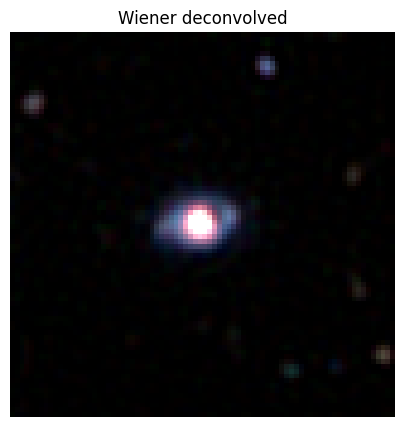

In [ ]:
deconvolved_channels = []

for i in range(y.size(1)):  # Assuming y has shape [N, C, H, W]
    # Extract the i-th channel from the image and kernel
    single_channel_image = y[0, i, :, :].cpu().numpy()
    single_channel_kernel = psf_kernel[i].cpu().numpy()
    
    # Apply Wiener filtering to the i-th channel
    deconvolved_channel = restoration.wiener(single_channel_image, single_channel_kernel, 1/2000)
    
    # Convert the deconvolved result back to a PyTorch tensor
    deconvolved_channel_tensor = torch.from_numpy(deconvolved_channel).unsqueeze(0)  # Add batch dimension
    deconvolved_channels.append(deconvolved_channel_tensor)

deconvolved_Wien_tensor = torch.cat(deconvolved_channels, dim=0)

display_as_pilimg(deconvolved_Wien_tensor,["Wiener deconvolved"]);

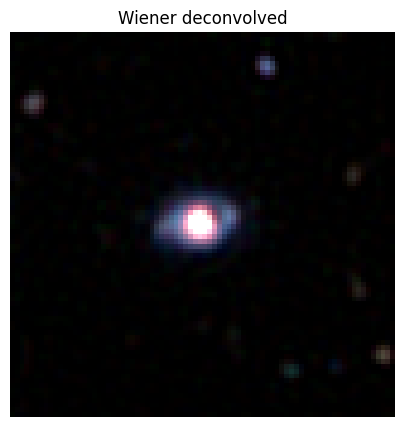

In [ ]:
display_as_pilimg(deconvolved_Wien_tensor,["Wiener deconvolved"]);

In [ ]:
import os

# Function to save the first 100 images from a .npz file as FITS
def save_images_as_fits(data, output_dir, name):
    # Load the data from .npz file
    images = data

    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create the full path for each image
    fits_path = os.path.join(output_dir, f'image_{name}.fits')

    # Create a FITS HDU object for each channel
    hdu_r = fits.PrimaryHDU(images[0,0])
    hdu_g = fits.ImageHDU(images[0,1])
    hdu_b = fits.ImageHDU(images[0,2])

    # Create an HDU list and write to the FITS file
    hdul = fits.HDUList([hdu_r, hdu_g, hdu_b])
    hdul.writeto(fits_path, overwrite=True)


output_dir = '/gpfswork/rech/tkc/uwa51yi/DDPMv2/improved-diffusion/test_deconv'

# Call the function
save_images_as_fits(composition2(restored_image).detach().cpu().numpy(), output_dir, 'restored_conv')
save_images_as_fits(y.detach().cpu().numpy(), output_dir, 'realistic_conv')
save_images_as_fits(composition2(x_true).detach().cpu().numpy(), output_dir, 'true_conv')
save_images_as_fits(y.detach().cpu().numpy() - composition2(x_true).detach().cpu().numpy(), output_dir, 'diff_realistic_true_conv')